In [25]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [26]:
# import pandas as pd
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import LabelEncoder

# # Load the dataset
# df = pd.read_csv("images.csv")

# # Split into features for MLP and image paths for CNN
# image_paths = df['Path']
# features = df.drop(columns=['Path', 'Target', 'Image_Name']).values
# targets = df['Target'].values

# # Encode labels
# label_encoder = LabelEncoder()
# targets_encoded = label_encoder.fit_transform(targets)

# # Split the data
# X_train_img, X_test_img, X_train_feat, X_test_feat, y_train, y_test = train_test_split(
#     image_paths, features, targets_encoded, test_size=0.2, random_state=42
# )

# print(f"Image training set: {X_train_img.shape}")
# print(f"Feature training set: {X_train_feat.shape}")
# print(f"Target training set: {y_train.shape}")

In [27]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Load the dataset
df = pd.read_csv("images.csv")

# Split into features for MLP and image paths for CNN
image_paths = df['Path']
features = df.drop(columns=['Path', 'Target', 'Image_Name']).values
targets = df['Target'].values

# Encode labels
label_encoder = LabelEncoder()
targets_encoded = label_encoder.fit_transform(targets)

# Split the data: Ensure image_paths, features, and targets are split together
X_train_img, X_test_img, X_train_feat, X_test_feat, y_train, y_test = train_test_split(
    image_paths, features, targets_encoded, test_size=0.2, random_state=42, stratify=targets_encoded
)

# Check the shapes of the splits
print(f"Image training set: {X_train_img.shape}")
print(f"Feature training set: {X_train_feat.shape}")
print(f"Target training set: {y_train.shape}")


Image training set: (388,)
Feature training set: (388, 18)
Target training set: (388,)


# CNN

In [28]:
import numpy as np
from tensorflow.keras.utils import img_to_array, load_img

def preprocess_images(image_paths, target_size=(128, 128)):
    images = []
    for path in image_paths:
        # Load and preprocess each image
        image = load_img(path, target_size=target_size)
        image = img_to_array(image) / 255.0  # Normalize
        images.append(image)
    return np.array(images)

# Preprocess images
X_train_cnn = preprocess_images(X_train_img)
X_test_cnn = preprocess_images(X_test_img)

print(f"CNN Input Shape: {X_train_cnn.shape}")

CNN Input Shape: (388, 128, 128, 3)


In [29]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Define CNN model with updated hyperparameters
cnn_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),  # Dropout rate set to 0.3 as per best parameters
    Dense(1, activation='sigmoid')  # Binary classification
])

# Compile the model with updated learning rate
cnn_model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model with updated epochs and batch size
cnn_model.fit(X_train_cnn, y_train, epochs=5, batch_size=32, validation_split=0.1)

# CNN Predictions
cnn_predictions = cnn_model.predict(X_test_cnn).flatten()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 214ms/step - accuracy: 0.4872 - loss: 0.7169 - val_accuracy: 0.5128 - val_loss: 0.6722
Epoch 2/5
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 155ms/step - accuracy: 0.5729 - loss: 0.6833 - val_accuracy: 0.6410 - val_loss: 0.6727
Epoch 3/5
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 156ms/step - accuracy: 0.5737 - loss: 0.6645 - val_accuracy: 0.5385 - val_loss: 0.6943
Epoch 4/5
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 154ms/step - accuracy: 0.6874 - loss: 0.6120 - val_accuracy: 0.6667 - val_loss: 0.6572
Epoch 5/5
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 138ms/step - accuracy: 0.7359 - loss: 0.5776 - val_accuracy: 0.6154 - val_loss: 0.6671
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/stepWARNING:tensorflow:6 out of the last 12 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x1177cf6a0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors 

In [30]:
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve, f1_score
import matplotlib.pyplot as plt

cnn_predictions_binary = (cnn_predictions > 0.5).astype(int) # convert to 0 or 1

cnn_accuracy = accuracy_score(y_test, cnn_predictions_binary)
cnn_precision = precision_score(y_test, cnn_predictions_binary)
cnn_recall = recall_score(y_test, cnn_predictions_binary)
cnn_roc_auc = roc_auc_score(y_test, cnn_predictions)
cnn_f1_score = f1_score(y_test, cnn_predictions_binary)

print(f"CNN Test Accuracy: {cnn_accuracy:.4f}")
print(f"CNN Test Precision: {cnn_precision:.4f}")
print(f"CNN Test Recall: {cnn_recall:.4f}")
print(f"CNN Test ROC-AUC: {cnn_roc_auc:.4f}")
print(f"CNN Test F1 Score: {cnn_f1_score:.4f}")

CNN Test Accuracy: 0.6804
CNN Test Precision: 0.7419
CNN Test Recall: 0.5000
CNN Test ROC-AUC: 0.6769
CNN Test F1 Score: 0.5974


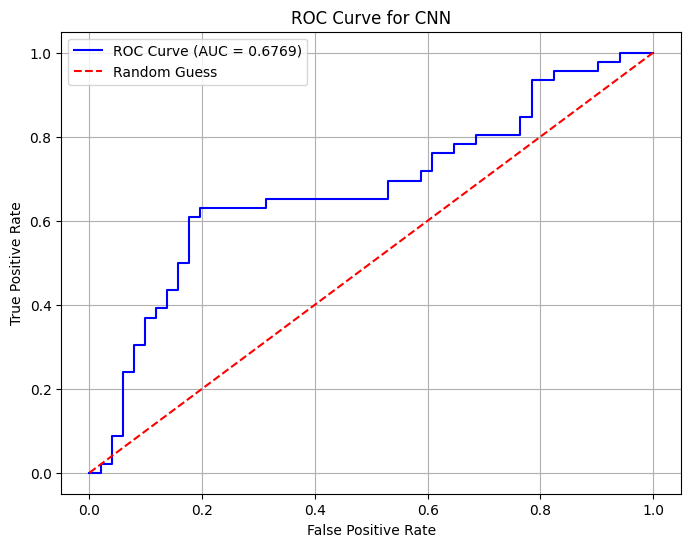

In [31]:
# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, cnn_predictions)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f"ROC Curve (AUC = {cnn_roc_auc:.4f})")
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label="Random Guess")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for CNN')
plt.legend()
plt.grid()
plt.show()

Epoch 1/5
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 148ms/step - accuracy: 0.7483 - loss: 0.5618 - val_accuracy: 0.6410 - val_loss: 0.6521
Epoch 2/5
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 145ms/step - accuracy: 0.7686 - loss: 0.5262 - val_accuracy: 0.6154 - val_loss: 0.6857
Epoch 3/5
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 144ms/step - accuracy: 0.7461 - loss: 0.5432 - val_accuracy: 0.6410 - val_loss: 0.6429
Epoch 4/5
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 158ms/step - accuracy: 0.8061 - loss: 0.4886 - val_accuracy: 0.6410 - val_loss: 0.6504
Epoch 5/5
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 141ms/step - accuracy: 0.7896 - loss: 0.4788 - val_accuracy: 0.6154 - val_loss: 0.6837


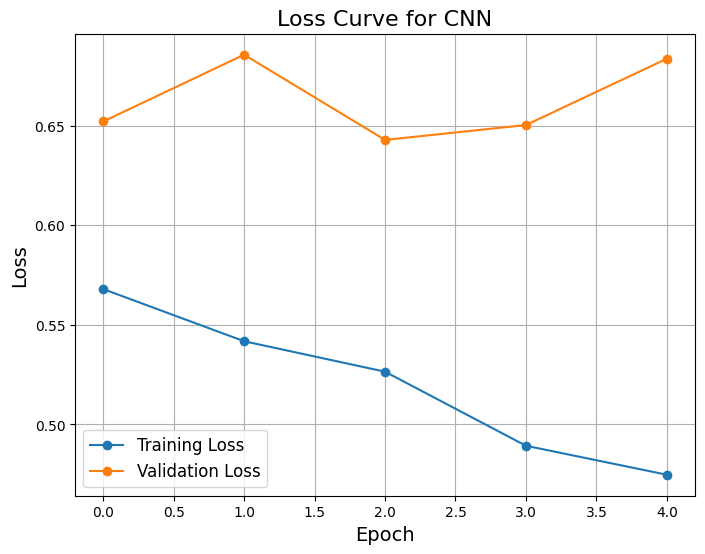

In [32]:
import matplotlib.pyplot as plt

# Train the CNN and save the history
history = cnn_model.fit(X_train_cnn, y_train, epochs=5, batch_size=32, validation_split=0.1)

# Extract the loss values
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot the training and validation loss
plt.figure(figsize=(8, 6))
plt.plot(train_loss, label='Training Loss', marker='o')
plt.plot(val_loss, label='Validation Loss', marker='o')
plt.title('Loss Curve for CNN', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

Epoch 1/16
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 146ms/step - accuracy: 0.8101 - loss: 0.4571 - val_accuracy: 0.6667 - val_loss: 0.6470
Epoch 2/16
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 143ms/step - accuracy: 0.8210 - loss: 0.4322 - val_accuracy: 0.6410 - val_loss: 0.6490
Epoch 3/16
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 139ms/step - accuracy: 0.8285 - loss: 0.4232 - val_accuracy: 0.6154 - val_loss: 0.6998
Epoch 4/16
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 140ms/step - accuracy: 0.8601 - loss: 0.4042 - val_accuracy: 0.6154 - val_loss: 0.7202
Epoch 5/16
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 147ms/step - accuracy: 0.8710 - loss: 0.3957 - val_accuracy: 0.5897 - val_loss: 0.7444
Epoch 6/16
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 147ms/step - accuracy: 0.8672 - loss: 0.3980 - val_accuracy: 0.5385 - val_loss: 0.7841
Epoch 7/16
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 141ms/step - accuracy: 0.8099 - loss: 0.4275 - val_accuracy: 0.6154 - val_loss: 0.7184
Epoch 8/16
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 141ms/step - accuracy: 0.8972 - loss: 0.3283 - val_accuracy: 0.

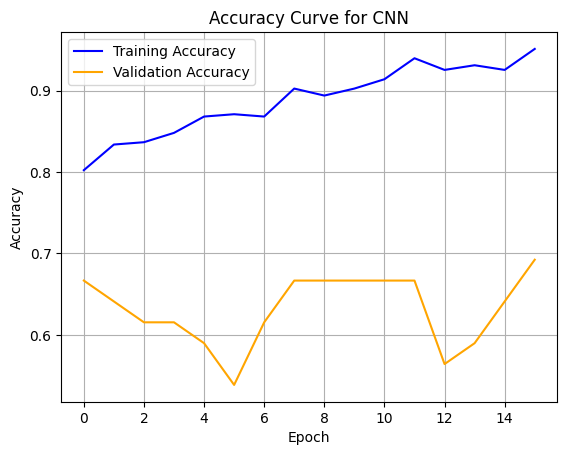

In [33]:
import matplotlib.pyplot as plt

# Train the model and store history
history = cnn_model.fit(X_train_cnn, y_train, epochs=16, batch_size=32, validation_split=0.1)

# Get the accuracy history from the training and validation data
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Plotting the accuracy curve
plt.plot(train_acc, label='Training Accuracy', color='blue')
plt.plot(val_acc, label='Validation Accuracy', color='orange')
plt.title('Accuracy Curve for CNN')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# MLP

In [34]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

In [35]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier

# Define the pipeline with the best parameters from GridSearchCV
mlp_model = Pipeline([
    ('scaler', StandardScaler()),  # Step 1: Scale features
    ('mlp', MLPClassifier(
        activation='tanh',  # Best activation function
        alpha=0.0001,       # Best alpha (regularization strength)
        hidden_layer_sizes=(100, 50),  # Best hidden layer sizes
        learning_rate_init=0.01,  # Best learning rate
        solver='adam',           # Best solver
        max_iter=500,            # Best number of iterations
        random_state=42
    ))  # Step 2: Train MLP
])

# Fit the pipeline on the training data
mlp_model.fit(X_train_feat, y_train)

# Predict on the test set
mlp_predictions = mlp_model.predict(X_test_feat)

# Optionally, print the accuracy or other metrics
# test_accuracy = pipeline.score(X_test_feat, y_test)
# print(f"Test Accuracy: {test_accuracy:.4f}")


In [36]:
from sklearn.metrics import accuracy_score

# Get probabilities for the positive class (class 1)
mlp_predictions_proba = mlp_model.predict_proba(X_test_feat)[:, 1]

# Convert probabilities to binary class predictions using threshold (0.5)
mlp_predictions = (mlp_predictions_proba >= 0.5).astype(int)

# Calculate accuracy
mlp_accuracy = accuracy_score(y_test, mlp_predictions)
print(f"MLP Test Accuracy: {mlp_accuracy:.4f}")


MLP Test Accuracy: 1.0000


In [37]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

mlp_predictions_proba = mlp_model.predict_proba(X_test_feat)[:, 1]
mlp_predictions = (mlp_predictions_proba >= 0.5).astype(int)

# Calculate precision and recall
mlp_precision = precision_score(y_test, mlp_predictions)
mlp_recall = recall_score(y_test, mlp_predictions)
mlp_roc_auc = roc_auc_score(y_test, mlp_predictions_proba)
mlp_f1_score = f1_score(y_test, mlp_predictions)

print(f"MLP Test Accuracy: {mlp_accuracy:.4f}")
print(f"MLP Test Precision: {mlp_precision:.4f}")
print(f"MLP Test Recall: {mlp_recall:.4f}")
print(f"MLP Test ROC-AUC: {mlp_roc_auc:.4f}")
print(f"MLP Test F1 Score: {mlp_f1_score:.4f}")

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, mlp_predictions_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='orange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2)  # Diagonal line (random classifier)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

MLP Test Accuracy: 1.0000
MLP Test Precision: 1.0000
MLP Test Recall: 1.0000
MLP Test ROC-AUC: 1.0000
MLP Test F1 Score: 1.0000


NameError: name 'roc_auc' is not defined

<Figure size 800x600 with 0 Axes>

# ensemble

In [10]:
from sklearn.metrics import accuracy_score

# Simple Averaging for ensemble predictions
weights = [0.5, 0.5]  # Equal weights for CNN and MLP
combined_predictions = (weights[0] * cnn_predictions) + (weights[1] * mlp_predictions)
final_predictions = (combined_predictions > 0.5).astype(int)

# Evaluate the ensemble model's accuracy
ensemble_accuracy = accuracy_score(y_test, final_predictions)
print(f"Ensemble Accuracy: {ensemble_accuracy:.4f}")


Ensemble Accuracy: 1.0000


In [11]:
import numpy as np
from sklearn.metrics import accuracy_score

# Define a grid of weights
weights = np.linspace(0, 1, 21)  # 21 values from 0.0 to 1.0

best_accuracy = 0
best_weights = (0.5, 0.5)  # Default to equal weights

for cnn_weight in weights:
    mlp_weight = 1 - cnn_weight  # Ensure weights sum to 1
    combined_predictions = (cnn_weight * cnn_predictions) + (mlp_weight * mlp_predictions)
    final_predictions = (combined_predictions > 0.5).astype(int)
    accuracy = accuracy_score(y_test, final_predictions)
    
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_weights = (cnn_weight, mlp_weight)

print(f"Best Weights: CNN={best_weights[0]}, MLP={best_weights[1]}")
print(f"Best Ensemble Accuracy: {best_accuracy:.4f}")


Best Weights: CNN=0.0, MLP=1.0
Best Ensemble Accuracy: 1.0000


In [12]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
import numpy as np

# Assuming cnn_predictions and mlp_predictions are the predicted probabilities (not raw predictions)

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
best_accuracy = 0
best_weights = (0.5, 0.5)

# List of weights to iterate over
weights = np.linspace(0, 1, num=11)  # Example weights: [0.0, 0.1, ..., 1.0]

for cnn_weight in weights:
    mlp_weight = 1 - cnn_weight
    fold_accuracies = []
    
    for train_index, test_index in kf.split(cnn_predictions, y_test):  # Pass features and labels
        # Create train/test splits for cross-validation
        cnn_train, cnn_test = cnn_predictions[train_index], cnn_predictions[test_index]
        mlp_train, mlp_test = mlp_predictions[train_index], mlp_predictions[test_index]
        y_train_fold, y_test_fold = y_test[train_index], y_test[test_index]
        
        # Combine predictions for the fold
        combined_test = (cnn_weight * cnn_test) + (mlp_weight * mlp_test)
        final_test = (combined_test > 0.5).astype(int)  # Convert probabilities to binary predictions
        fold_accuracy = accuracy_score(y_test_fold, final_test)
        fold_accuracies.append(fold_accuracy)
    
    # Average accuracy across folds
    mean_accuracy = np.mean(fold_accuracies)
    if mean_accuracy > best_accuracy:
        best_accuracy = mean_accuracy
        best_weights = (cnn_weight, mlp_weight)

print(f"Best Weights from Cross-Validation: CNN={best_weights[0]}, MLP={best_weights[1]}")
print(f"Best Cross-Validated Accuracy: {best_accuracy:.4f}")


Best Weights from Cross-Validation: CNN=0.0, MLP=1.0
Best Cross-Validated Accuracy: 1.0000


In [13]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

# Prepare meta-model features
meta_features = np.column_stack((cnn_predictions, mlp_predictions))

# Define hyperparameter grid
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],  # Regularization strength
    'solver': ['liblinear', 'lbfgs']
}

# Perform grid search
meta_model = LogisticRegression(random_state=42)
# grid_search = GridSearchCV(meta_model, param_grid, cv=5, scoring='accuracy')
# grid_search.fit(meta_features, y_test)

from sklearn.model_selection import GridSearchCV

grid_search = GridSearchCV(meta_model, param_grid, cv=StratifiedKFold(n_splits=5), scoring='accuracy')
grid_search.fit(meta_features, y_test)


print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Meta-Model Accuracy: {grid_search.best_score_:.4f}")


Best Parameters: {'C': 0.01, 'solver': 'liblinear'}
Best Meta-Model Accuracy: 1.0000


In [14]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, accuracy_score

# Simple Averaging for ensemble predictions
weights = [0.5, 0.5]  # Equal weights for CNN and MLP
combined_predictions = (weights[0] * cnn_predictions) + (weights[1] * mlp_predictions)
final_predictions = (combined_predictions > 0.5).astype(int)

# Evaluate the ensemble model's accuracy
ensemble_accuracy = accuracy_score(y_test, final_predictions)
print(f"Ensemble Accuracy: {ensemble_accuracy:.4f}")

# Calculate Precision, Recall, and F1-Score
ensemble_precision = precision_score(y_test, final_predictions, average='binary')  # 'binary' for binary classification
ensemble_recall = recall_score(y_test, final_predictions, average='binary')
ensemble_f1_score = f1_score(y_test, final_predictions, average='binary')

# Print the metrics
print(f"Precision: {ensemble_precision:.4f}")
print(f"Recall: {ensemble_recall:.4f}")
print(f"F1-Score: {ensemble_f1_score:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_test, final_predictions)
print("Confusion Matrix:")
print(cm)


Ensemble Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1-Score: 1.0000
Confusion Matrix:
[[51  0]
 [ 0 46]]


# visuals for presentation

## cnn

In [15]:
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve, f1_score
import matplotlib.pyplot as plt

cnn_predictions_binary = (cnn_predictions > 0.5).astype(int) # convert to 0 or 1

cnn_accuracy = accuracy_score(y_test, cnn_predictions_binary)
cnn_precision = precision_score(y_test, cnn_predictions_binary)
cnn_recall = recall_score(y_test, cnn_predictions_binary)
cnn_roc_auc = roc_auc_score(y_test, cnn_predictions)
cnn_f1_score = f1_score(y_test, cnn_predictions_binary)

print(f"CNN Test Accuracy: {cnn_accuracy:.4f}")
print(f"CNN Test Precision: {cnn_precision:.4f}")
print(f"CNN Test Recall: {cnn_recall:.4f}")
print(f"CNN Test ROC-AUC: {cnn_roc_auc:.4f}")
print(f"CNN Test F1 Score: {cnn_f1_score:.4f}")

CNN Test Accuracy: 0.6804
CNN Test Precision: 0.6744
CNN Test Recall: 0.6304
CNN Test ROC-AUC: 0.6748
CNN Test F1 Score: 0.6517


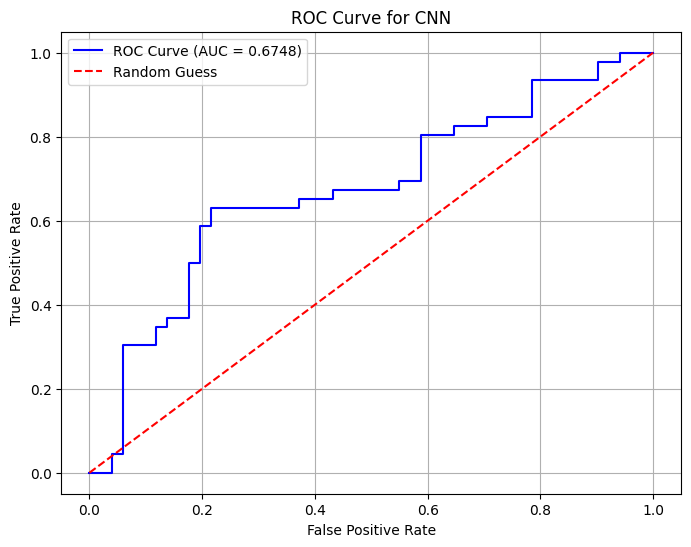

In [16]:
# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, cnn_predictions)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f"ROC Curve (AUC = {cnn_roc_auc:.4f})")
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label="Random Guess")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for CNN')
plt.legend()
plt.grid()
plt.show()

Epoch 1/5
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 176ms/step - accuracy: 0.7320 - loss: 0.5919 - val_accuracy: 0.6154 - val_loss: 0.6614
Epoch 2/5
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 171ms/step - accuracy: 0.7506 - loss: 0.5624 - val_accuracy: 0.6154 - val_loss: 0.6751
Epoch 3/5
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 166ms/step - accuracy: 0.7542 - loss: 0.5470 - val_accuracy: 0.6154 - val_loss: 0.6808
Epoch 4/5
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 198ms/step - accuracy: 0.7303 - loss: 0.5658 - val_accuracy: 0.5641 - val_loss: 0.7077
Epoch 5/5
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 162ms/step - accuracy: 0.7133 - loss: 0.5747 - val_accuracy: 0.6154 - val_loss: 0.6523


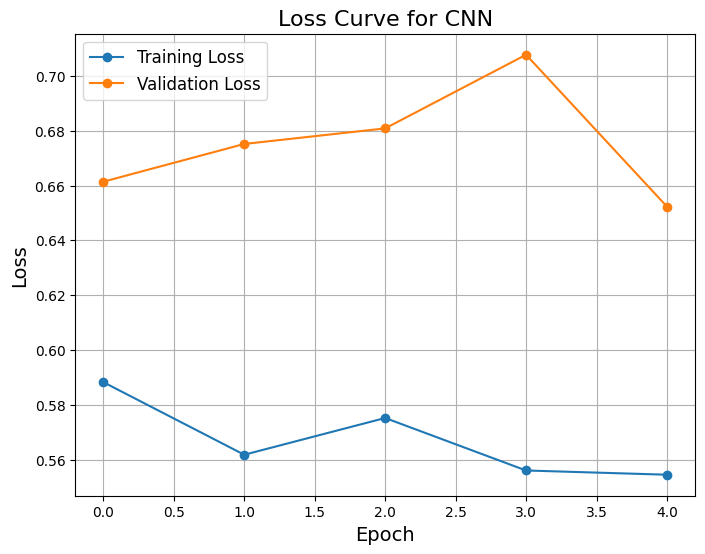

In [17]:
import matplotlib.pyplot as plt

# Train the CNN and save the history
history = cnn_model.fit(X_train_cnn, y_train, epochs=5, batch_size=32, validation_split=0.1)

# Extract the loss values
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot the training and validation loss
plt.figure(figsize=(8, 6))
plt.plot(train_loss, label='Training Loss', marker='o')
plt.plot(val_loss, label='Validation Loss', marker='o')
plt.title('Loss Curve for CNN', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

Epoch 1/50


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 220ms/step - accuracy: 0.5247 - loss: 0.7722 - val_accuracy: 0.4872 - val_loss: 0.7614 - learning_rate: 1.0000e-04
Epoch 2/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 200ms/step - accuracy: 0.5711 - loss: 0.6851 - val_accuracy: 0.4872 - val_loss: 0.7346 - learning_rate: 1.0000e-04
Epoch 3/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 221ms/step - accuracy: 0.5651 - loss: 0.6888 - val_accuracy: 0.6923 - val_loss: 0.6684 - learning_rate: 1.0000e-04
Epoch 4/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 185ms/step - accuracy: 0.6762 - loss: 0.6227 - val_accuracy: 0.6410 - val_loss: 0.6519 - learning_rate: 1.0000e-04
Epoch 5/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 213ms/step - accuracy: 0.7451 - loss: 0.5788 - val_accuracy: 0.6154 - val_loss: 0.6355 - learning_rate: 1.0000e-04
Epoch 6/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 179ms/step - accuracy: 0.7381 - loss: 0.5489 - val_accuracy: 0.6410 - val_loss: 0.6437 - learning_rate: 1.0000e-04
Epoch 7/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 217ms/step - accuracy: 0.7322 - lo

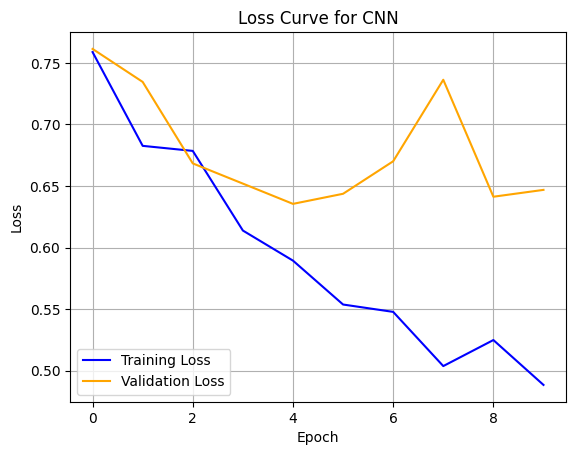

In [18]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Define early stopping and reduce learning rate on plateau callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor the validation loss
    patience=5,  # Stop after 5 epochs without improvement
    restore_best_weights=True  # Restore the best model weights
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',  # Monitor the validation loss
    factor=0.5,  # Reduce learning rate by 50%
    patience=3,  # Wait 3 epochs for no improvement
    min_lr=1e-6  # Minimum learning rate limit
)

# Define the CNN model as before
cnn_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),  # Dropout rate set to 0.3 as per best parameters
    Dense(1, activation='sigmoid')  # Binary classification
])

# Compile the model with updated learning rate
cnn_model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model with callbacks (early stopping and reduce learning rate)
history = cnn_model.fit(
    X_train_cnn, y_train, 
    epochs=50,  # Training for more epochs
    batch_size=32, 
    validation_split=0.1,
    callbacks=[early_stopping, reduce_lr]  # Include both callbacks
)

# CNN Predictions
cnn_predictions = cnn_model.predict(X_test_cnn).flatten()

# Optionally, you can plot the loss curve again after training with callbacks
import matplotlib.pyplot as plt

# Extract training and validation loss from the history
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot the loss curve
plt.plot(train_loss, label='Training Loss', color='blue')
plt.plot(val_loss, label='Validation Loss', color='orange')
plt.title('Loss Curve for CNN')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


Epoch 1/16
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 168ms/step - accuracy: 0.7200 - loss: 0.5637 - val_accuracy: 0.6667 - val_loss: 0.6608
Epoch 2/16
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 236ms/step - accuracy: 0.6763 - loss: 0.5703 - val_accuracy: 0.6410 - val_loss: 0.6359
Epoch 3/16
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 157ms/step - accuracy: 0.7640 - loss: 0.5483 - val_accuracy: 0.6410 - val_loss: 0.6511
Epoch 4/16
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 176ms/step - accuracy: 0.7843 - loss: 0.5172 - val_accuracy: 0.6410 - val_loss: 0.6441
Epoch 5/16
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 214ms/step - accuracy: 0.7692 - loss: 0.5301 - val_accuracy: 0.6154 - val_loss: 0.6523
Epoch 6/16
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 165ms/step - accuracy: 0.7895 - loss: 0.5004 - val_accuracy: 0.6410 - val_loss: 0.6399
Epoch 7/16
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 260ms/step - accuracy: 0.8055 - loss: 0.5008 - val_accuracy: 0.6154 - val_loss: 0.6451
Epoch 8/16
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 181ms/step - accuracy: 0.8445 - loss: 0.4630 - val_accuracy: 0.

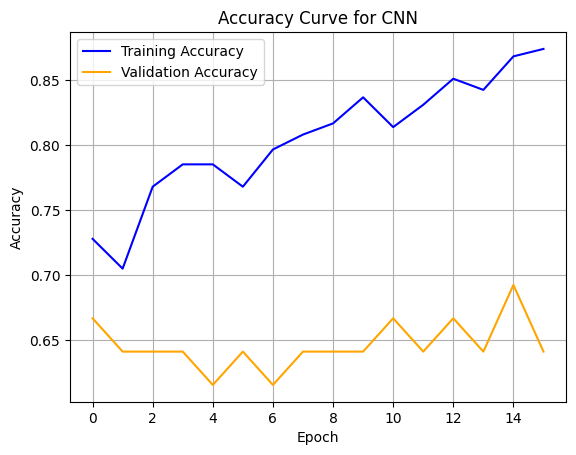

In [19]:
import matplotlib.pyplot as plt

# Train the model and store history
history = cnn_model.fit(X_train_cnn, y_train, epochs=16, batch_size=32, validation_split=0.1)

# Get the accuracy history from the training and validation data
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Plotting the accuracy curve
plt.plot(train_acc, label='Training Accuracy', color='blue')
plt.plot(val_acc, label='Validation Accuracy', color='orange')
plt.title('Accuracy Curve for CNN')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

## mlp

MLP Test Accuracy: 1.0000
MLP Test Precision: 1.0000
MLP Test Recall: 1.0000
MLP Test ROC-AUC: 1.0000
MLP Test F1 Score: 1.0000


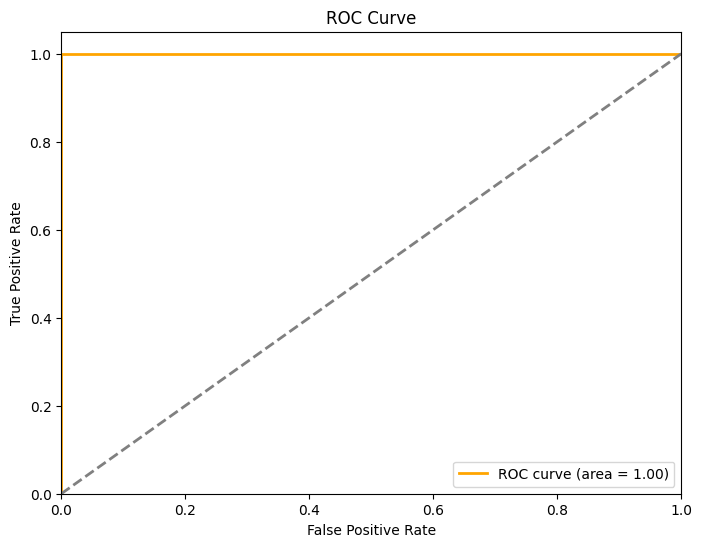

In [20]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

mlp_predictions_proba = mlp_model.predict_proba(X_test_feat)[:, 1]
mlp_predictions = (mlp_predictions_proba >= 0.5).astype(int)

# Calculate precision and recall
mlp_precision = precision_score(y_test, mlp_predictions)
mlp_recall = recall_score(y_test, mlp_predictions)
mlp_roc_auc = roc_auc_score(y_test, mlp_predictions_proba)
mlp_f1_score = f1_score(y_test, mlp_predictions)

print(f"MLP Test Accuracy: {mlp_accuracy:.4f}")
print(f"MLP Test Precision: {mlp_precision:.4f}")
print(f"MLP Test Recall: {mlp_recall:.4f}")
print(f"MLP Test ROC-AUC: {mlp_roc_auc:.4f}")
print(f"MLP Test F1 Score: {mlp_f1_score:.4f}")

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, mlp_predictions_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='orange', lw=2, label=f'ROC curve (area = {mlp_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2)  # Diagonal line (random classifier)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

## ensembling

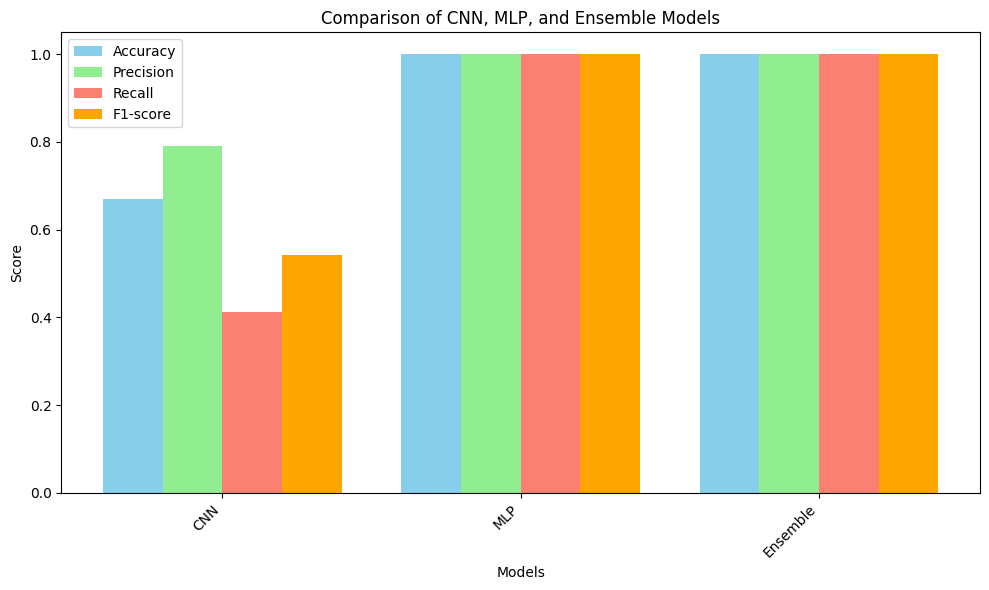

In [54]:
import matplotlib.pyplot as plt
import numpy as np

# Model names
models = ['CNN', 'MLP', 'Ensemble']

# Performance metrics (Accuracy, Precision, Recall, F1-score)
accuracy = [cnn_accuracy, mlp_accuracy, ensemble_accuracy]
precision = [cnn_precision, mlp_precision, ensemble_precision]
recall = [cnn_recall, mlp_recall, ensemble_recall]
f1_score = [cnn_f1_score, mlp_f1_score, ensemble_f1_score]

# Set positions for the bars
x = np.arange(len(models))

# Bar width
width = 0.2

# Create subplots
fig, ax = plt.subplots(figsize=(10, 6))

# Plot bars for each metric
ax.bar(x - 1.5*width, accuracy, width, label='Accuracy', color='skyblue')
ax.bar(x - 0.5*width, precision, width, label='Precision', color='lightgreen')
ax.bar(x + 0.5*width, recall, width, label='Recall', color='salmon')
ax.bar(x + 1.5*width, f1_score, width, label='F1-score', color='orange')

# Add labels, title, and custom x-axis tick labels
ax.set_xlabel('Models')
ax.set_ylabel('Score')
ax.set_title('Comparison of CNN, MLP, and Ensemble Models')
ax.set_xticks(x)
ax.set_xticklabels(models, rotation=45, ha="right")
ax.legend()

# Display the plot
plt.tight_layout()
plt.show()
